Preprocess 8: Scaled Dataset (Optional)
=======================================

In this tool we mark regions of the image that has signal in the proximity of the lens and source that may impact our
model fitting. By marking these regions we will scale the image to values near zero and the noise-map to large values
such that our model-fit ignores these regions.

Why not just mask these regions instead? The reason is because of inversions which reconstruct the lensed source's
light on a pixelized grid. Masking regions of the image removes them entirely from the fitting proceure. This means
their deflection angles are omitted and they are not traced to the source-plane, creating discontinuities in the
source `Pixelization` which can negatively impact the `Regularization` scheme.

However, by retaining them in the mask but simply scaling their values these discontinuities are omitted.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

#%matplotlib inline
from os import path
import autolens as al
import autolens.plot as aplt

import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The path where the dataset we scale is loaded from, which 
is `dataset/imaging/no_lens_light/mass_sie__source_sersic__intervening_objects`

In [2]:
dataset_type = "imaging"
dataset_label = "no_lens_light"
dataset_name = "mass_sie__source_sersic__intervening_objects"
dataset_path = path.join("dataset", dataset_type, dataset_label, dataset_name)

If you use this tool for your own dataset, you *must* double check this pixel scale is correct!

In [3]:
pixel_scales = 0.1

First, load the dataset image, so that the location of galaxies is clear when scaling the noise-map.

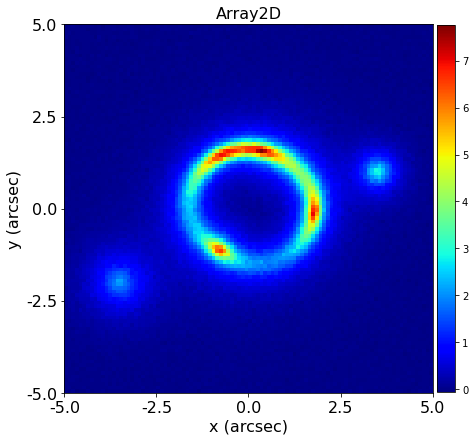

In [4]:
image = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "image.fits"), pixel_scales=pixel_scales
)

array_plotter = aplt.Array2DPlotter(array=image)
array_plotter.figure()

Next, load the noise-map, which we will use the scale the noise-map.

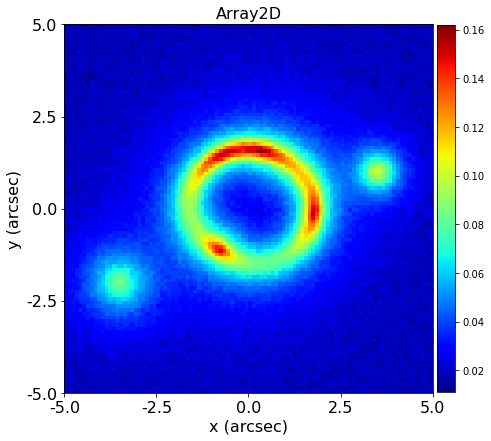

In [5]:
noise_map = al.Array2D.from_fits(
    file_path=path.join(dataset_path, "noise_map.fits"), pixel_scales=pixel_scales
)

array_plotter = aplt.Array2DPlotter(array=noise_map)
array_plotter.figure()

Now lets plot the signal to noise-map, which will be reduced to nearly zero one we scale the noise.

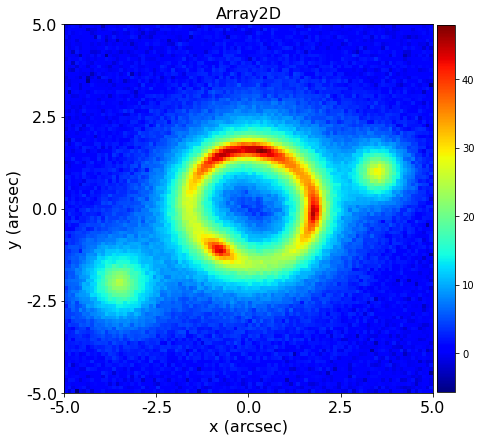

In [6]:
array_plotter = aplt.Array2DPlotter(array=image / noise_map)
array_plotter.figure()

First, we manually define a mask corresponding to the regions of the image we will scale.

In [7]:
mask = al.Mask2D.unmasked(
    shape_native=image.shape_native, pixel_scales=image.pixel_scales
)
mask[25:55, 77:96] = True
mask[55:85, 3:27] = True

We are going to change the image flux values to low values. Note zeros, but values consistent with the background
signa in the image, which we can estimate from the image itself.

In [8]:
background_level = al.preprocess.background_noise_map_from_edges_of_image(
    image=image, no_edges=2
)[0]

This function uses the mask to scale the appropriate regions of the image to the background level.

In [9]:
image = np.where(mask, background_level, image.native)
image = al.Array2D.manual_native(array=image, pixel_scales=pixel_scales)

To make our scaled image look as realistic as possible, we can optionally included some noise drawn from a Gaussian
distributon to replicate the noise-pattern in the image. This requires us to choose a gaussian_sigma value 
representative of the data, which you should choose via `trial and error` until you get a noise pattern that is
visually hard to discern from the rest of the image.

In [10]:
# gaussian_sigma = None
gaussian_sigma = 0.03

if gaussian_sigma is not None:
    random_noise = np.random.normal(
        loc=background_level, scale=gaussian_sigma, size=image.shape_native
    )
    image = np.where(mask, random_noise, image.native)
    image = al.Array2D.manual_native(array=image, pixel_scales=pixel_scales)

The new image is plotted for inspection.

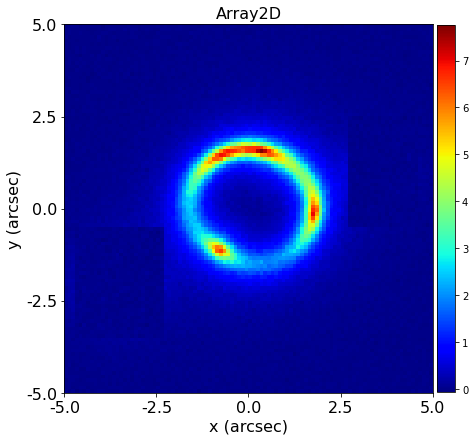

In [11]:
array_plotter = aplt.Array2DPlotter(array=image)
array_plotter.figure()

Now we`re happy with the image, lets output it to the dataset folder of the lens, so that we can load it from a .fits
file in our pipelines!

In [12]:
image.output_to_fits(
    file_path=path.join(dataset_path, "image_scaled.fits"), overwrite=True
)

Here, we manually increase the noise values at these points in the mask to extremely large values, such that the 
analysis essentially omits them.

In [13]:
noise_map = noise_map.native
noise_map[mask == True] = 1.0e8

The noise-map and signal to noise-map show the noise-map being scaled in the correct regions of the image.

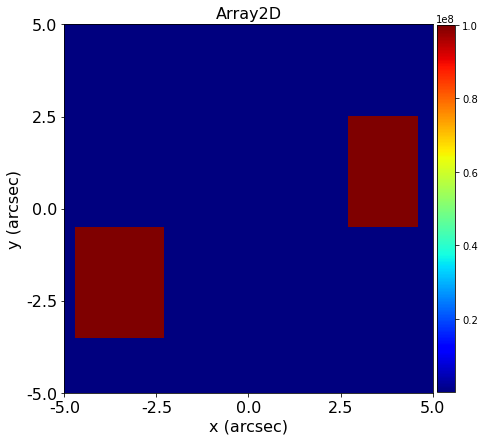

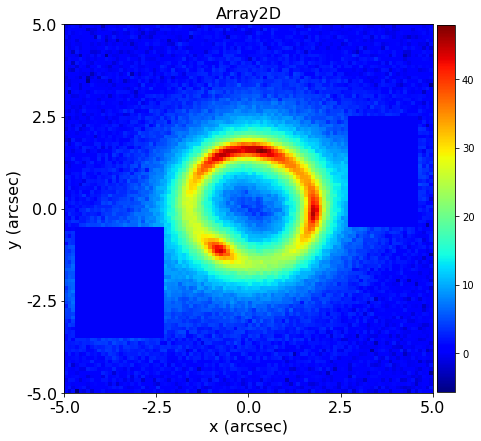

In [14]:
array_plotter = aplt.Array2DPlotter(array=noise_map)
array_plotter.figure()

array_plotter = aplt.Array2DPlotter(array=image / noise_map.slim)
array_plotter.figure()

Now we`re happy with the mask, lets output it to the dataset folder of the lens, so that we can load it from a .fits
file in our pipelines!

In [15]:
noise_map.output_to_fits(
    file_path=path.join(dataset_path, "noise_map_scaled.fits"), overwrite=True
)

Finally, we can output the scaled mask encase we need it in the future.

In [16]:
mask.output_to_fits(
    file_path=path.join(dataset_path, "mask_scaled.fits"), overwrite=True
)

The workspace also includes a GUI for image and noise-map scaling, which can be found at 
`autolens_workspace/notebooks/preprocess/imaging/gui/scaled_dataset.py`. This tools allows you `spray paint` on the image where 
an you want to scale, allow irregular patterns (i.e. not rectangles) to be scaled.